# ME5303 Digital Manufacturing 
## Assignment 5 - Question 1 and 2

### Date of Submission : 09 October 2017

Initial part of the code is utilising the B-Rep formulation that we developed for the earlier assignment. Later part of the code incorporates the algorithm developed to detect triangular pocket

In [101]:
#IMPORT REQD. LIBRARIES

%matplotlib notebook
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os

In [100]:
############### B-Rep Formulation ###############

# Part class which takes the directory of V, E, L, F as inputs
# V - Vertices
# E - Edges
# L - Loops
# F - Faces

class part:
    
    # Initialization Vector 
    def __init__(self, vert, edge, loop, face):
        
        self.dir_vert = vert
        self.dir_edge = edge
        self.dir_face = face
        self.dir_loop = loop        
        # Storing all the directories
        
    # Function for loading all the data
    def load(self):
        
        self.E = np.genfromtxt(self.dir_edge, dtype=float, delimiter=',')
        self.V = np.genfromtxt(self.dir_vert, dtype=float, delimiter=',')
        with open(self.dir_loop) as f:
            self.L = f.readlines()
        with open(self.dir_face) as f:
            self.F = f.readlines()
        self.L = [x.strip() for x in self.L] 
        self.F = [x.strip() for x in self.F] 

    # Function for equal scaling the axes
    def set_axes_equal(self):

        x_limits = self.ax.get_xlim3d()
        y_limits = self.ax.get_ylim3d()
        z_limits = self.ax.get_zlim3d()

        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)

        plot_radius = 0.5*max([x_range, y_range, z_range])

        self.ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        self.ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        self.ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
        
    # Function for Drawing lines as edges
    def draw_line(self,pA,pB,col):
        
        self.ax.plot([pA[0],pB[0]],[pA[1],pB[1]],[pA[2],pB[2]],color=col)
        
    # Function for rendering the edge with specified number
    def render_edge(self,edge_num,col):

        edge = self.E[edge_num-1]
        self.draw_line(self.V[int(edge[0]-1)],self.V[int(edge[1]-1)],col)

    # Function for rendering a loop
    def render_loop(self,loop_num,col):
        
        loop = self.L[loop_num-1]
        L1 = map(int, loop.split(','))
            
        for edge in L1:
            self.render_edge(edge,col)
            
    # Function for rendering a face
    def render_face(self,face_num,col):
        
        face = self.F[face_num]
        F1 = map(int, face.split(','))
            
        for loop in F1:
            self.render_loop(loop,col)
    
    # Function to render the body
    def render_body(self):
        
        for face_num in range(0,len(self.F)):
            self.render_face(face_num,'k')
            
        self.set_axes_equal()
        plt.show()
    
    # Canvas Initialize
    def init_canvas(self):
        
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.set_aspect('equal')
        self.ax.grid('off')
        self.ax.axis('off')
        
############### B-Rep Formulation Ends Here ###############

############### Functions developed for triangular pocket detection ###############
        
    # Func for finding area when a loop number is specified
    
    def calc_area(self,loop_num):
        
        loop = self.L[loop_num-1]
        L1 = map(int, loop.split(','))
        E = self.E
        V = self.V

        vc = []

        if E[int(L1[0])-1][0]== E[int(L1[1])-1][0] or E[int(L1[0])-1][0]==E[int(L1[1])-1][1]:
            vc.append(V[int(E[int(L1[0])-1][1])-1])

        else:
            vc.append(V[int(E[int(L1[0])-1][0])-1])

        for edge_num in L1:
            if np.array_equal(V[int(E[edge_num-1][0])-1],vc[len(vc)-1]):
                vc.append(V[int(E[edge_num-1][1])-1])
            else:
                vc.append(V[int(E[edge_num-1][0])-1])

        base = vc[0]
        for vert in range(len(vc)):
            vc[vert] = np.subtract(vc[vert],base)

        area = np.array([0,0,0])
        for i in range(1,len(vc)-1):
            area = np.add(area,np.cross(vc[i],vc[i+1]))

        area = np.divide(area,2)
        return area

        
    # Finding Reference Loop i.e., the loop with largest area- returns the index of the loop in that face
    
    
    def ref_loop(self,myface):
        
        face = self.F[myface-1]
        FF = map(int, face.split(','))
        
        if len(FF) is 1:
            refloop = FF[0]
        else:
            area = []
            for ln in FF:
                a = self.calc_area(ln)
                area.append(np.linalg.norm(a))
            refloop = FF[np.argmax(area)]
        
        return refloop
        
    # Func for detecting triangular slots
    def find_tri_slot(self):        
        
        # Finding faces that has more than 1 loops (Necessary for pockets on a face)
        F_L = []
        for f in self.F:
            FF = map(int, f.split(','))
            if len(FF) > 1:
                F_L.append(self.F.index(f)+1)
        
        # Finding loops with 3 edges
        
        for fn in F_L:
            
            r_loop = self.ref_loop(fn)
            L_3 = []
            av_3 = [] 
            
            face = self.F[fn-1]
            FF2 = map(int, face.split(','))
            
            for l in FF2:
                
                loop = self.L[l-1]
                LL = map(int, loop.split(','))
                if len(LL) is 3:
                    L_3.append(l)
                    a_v = self.calc_area(l)
                    av_3.append(a_v)
                    
            tripock = []
            
            av_3l = []
            for avs in av_3:
                av_3l.append(avs.tolist())
            
            av_ref = self.calc_area(r_loop)
            for av in av_3:
                if np.dot(av,av_ref)>0:
                    lindex = av_3l.index(av.tolist())
                    tripock.append(L_3[lindex])
                    
            edge_L = []      
            # Highlighting the pocket
            for tripocks in tripock:
                self.render_loop(tripocks,'r')
                
                loop1 = self.L[tripocks-1]
                LL1 = map(int, loop1.split(','))
                
                for i in LL1:
                    edge_L.append(i)
            
            for edges in edge_L:
                for L in range(len(self.L)):
                    if str(edges) in self.L[L]:
                        self.render_loop(L+1,'b')

        
        

### Mechanism of detection


__Assumption 1:__ _The feature is completely inside a given face and thus the face should contain at least two loops in order to be considered for triangular pocket (feature) detection_

__Assumption 2:__ _While constructing B-Rep, it is assumed, if an inner loop is in same sense (both CW or CCW) as the reference loop (loop with the largest area in the given face), it is pocket. If it is in opposite direction it is an outward extrusion_

We followed the following methodology for feature detection:

_First, the faces that have more than one loop are detected _

_For each such face, areas and area vectors of all the loops are determined (Method of determining area is furnsihed below). The loop with largest area, which would be the bounding loop, is taken as the reference loop._

_For each such face, triangular loops are detected and their area vector is determined. Triangular loops are detected as a loop having three edges._

_Once the triangular loops are obtained, their direction sense is compared with reference loop (by using a dot product between the area vectors) and if a pocket is detected, B Rep structure shows the pocket in blue color as shown below._

Consider a n-edged polygon, its area can be calculated as:

<img src="images/ngon.png" width = 30%>

$$Area = \frac{1}{2}[\vec{OB}\times\vec{OC}+\vec{OC}\times\vec{OD}+...+\vec{OM}\times\vec{ON}]$$

This concept of area vector is also used to deduce the direction of each loop relative to the reference loop.

#### Solution for part 1

Let us take the B-Rep structure of $Part  1$ and render the body before feature recognition

<IPython.core.display.Javascript object>


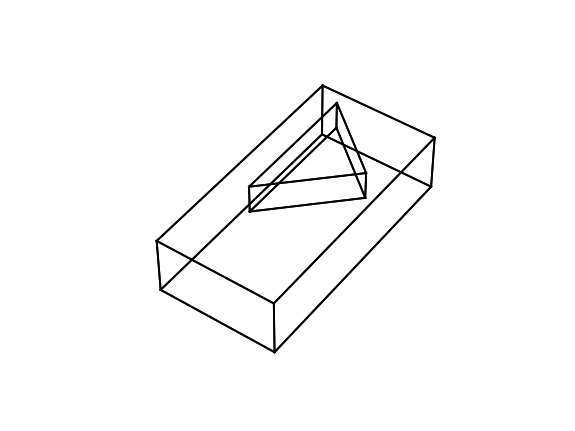

In [102]:
shape = part("P1/V","P1/E","P1/L","P1/F")
shape.init_canvas()
shape.load()
shape.render_body()

We then run our function - $find\_tri\_slot()$ to detect and highlight the pockets (if they exist)

<IPython.core.display.Javascript object>


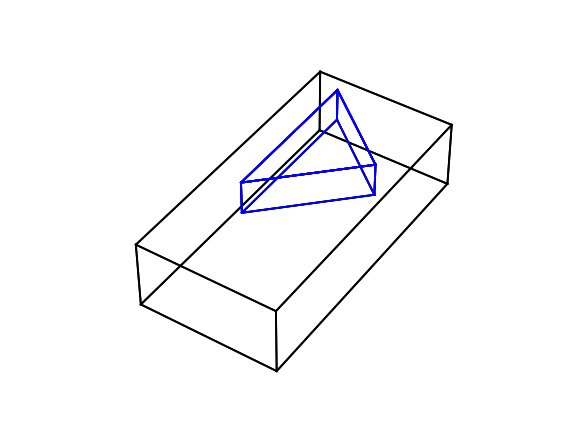

In [103]:
shape.init_canvas()
shape.render_body()
shape.find_tri_slot()

#### Solution for Part 2

Let us take the B-Rep structure of $Part  2$ and render the body before feature recognition

<IPython.core.display.Javascript object>


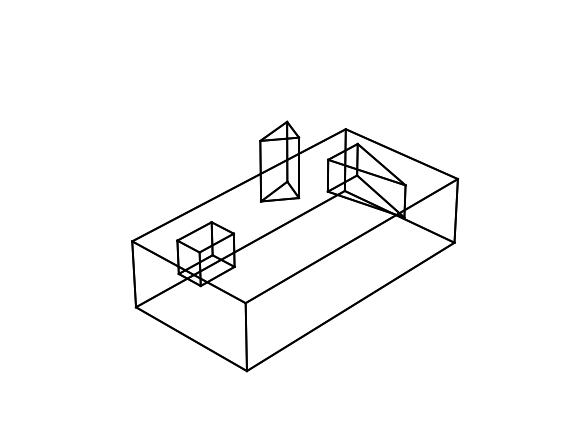

In [104]:
shape = part("P2/V","P2/E","P2/L","P2/F")
shape.init_canvas()
shape.load()
shape.render_body()

We'll check if it detects and highlights the pocket again, even in the presence of other elements.

<IPython.core.display.Javascript object>


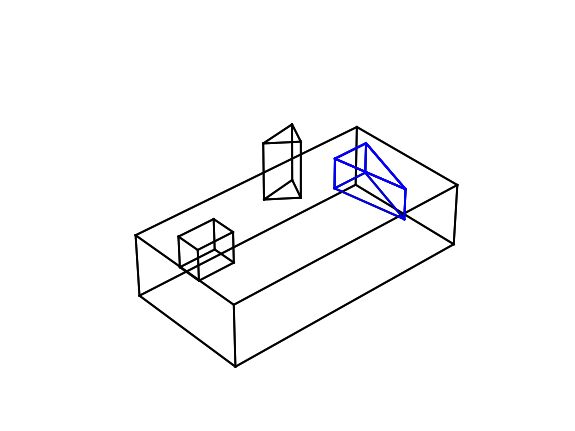

In [105]:
shape.init_canvas()
shape.render_body()
shape.find_tri_slot()

#### Testing for part with multiple triangular pockets

Here, we are additionally testing our methodology for different possibilities.

<IPython.core.display.Javascript object>


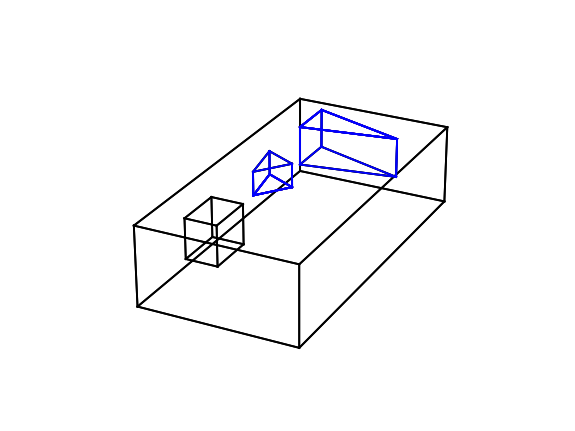

In [106]:
shape = part("P3/V","P3/E","P3/L","P3/F")
shape.init_canvas()
shape.load()
shape.render_body()
shape.find_tri_slot()

In conclusion, we observe that our method of detection of triangular pockets, although very specific to the feature, performs in a robust manner to detect and highlight the required feature.